In [1]:
%matplotlib inline

#from pylab import *
import numpy as np

from numpy import random
from numpy import fft
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
mpl.rcParams['figure.figsize'] = [15, 8]


In [3]:
import numpy.random as ra
def timmer_and_koenig_pds(pds_shape, n_ave=1):
    '''
    Generate a PDS given a pds shape and the total number of counts.
    '''
    n = len(pds_shape)

    # generate normal distributions for the real and imaginary
    # parts of the Fourier Transform, and multiply them for the
    # wanted spectral shape
    pds = 0
    for i in range(n_ave):
        real_part = ra.normal(0, 1, n) * np.sqrt(pds_shape * 0.5)
        img_part = ra.normal(0, 1, n) * np.sqrt(pds_shape * 0.5)
        pds += real_part ** 2 + img_part ** 2

    return pds / n_ave

def timmer_and_koenig(pds_shape):
    '''
    Generate a PDS given a pds shape and the total number of counts.
    '''
    n = len(pds_shape)

    # generate normal distributions for the real and imaginary
    # parts of the Fourier Transform, and multiply them for the
    # wanted spectral shape
    real_part = ra.normal(0, 1, n) * np.sqrt(pds_shape * 0.5)
    img_part = ra.normal(0, 1, n) * np.sqrt(pds_shape * 0.5)
    # create the positive frequencies of the FT
    half_ft = np.zeros(n, complex)
    for bin in range(0, n):
        half_ft[bin] = complex(real_part[bin], img_part[bin])
    half_ft[-1] = complex(real_part[-1], 0)

    # create the negative frequencies of the FT by reversing the
    # positive part and taking the complex conjugate
    mirror_half_ft = half_ft[::-1].conjugate()
    # the full FT is the concatenation of the negative part, the 0Hz element
    # and the positive part
    ft = np.concatenate(
        (np.array([complex(0., 0.)]),
         half_ft, mirror_half_ft[1:]))

    return np.array(ft)

from astropy.modeling.models import Lorentz1D

frequencies = np.arange(0, 100, 0.01)


# "Standard" Aperiodic Timing

## Contents

* Some statistics

* Not only coherent pulsations

* Optimizing your binning

* Significance

* Dead time

* Gaps


# Some statistics

For the statistical part, refer to [this very good review](http://www.iucaa.ernet.in/~astrosat/MIT-IUCAA_workshop_presentations/VanDerKlis1989_Fourier_Xray.pdf).

In High-energy astrophysics, we are usually working with event lists. 
The first procedure consists of the generation of _light curves_ -- a histogram of the event arrival times binned at fixed intervals.

The light curve follows the Poissonian statistics. The power density spectrum of such a light curve can be normalized in order to get a convenient statistical behavior, as follows:

$P(\omega) = \dfrac{2}{N_{\rm ph}} \mathcal{F}(\omega)\mathcal{F}^*(\omega)$

where $\mathcal{F}$ is the Fourier transform of the light curve.

In this particular normalization, if the lightcurve is Poissonian, the power density spectrum is distributed according to a Chi squared statistics with 2 degrees of freedom _in the absence of signal_ (Leahy+83). This is usually indicated with the Leahy normalization. 

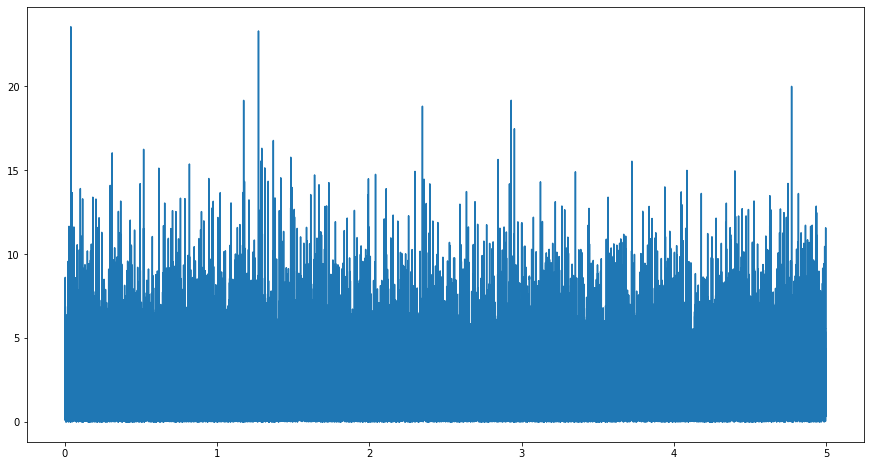

In [4]:
def rough_leahy_pds(lc, dt):
    nbin = len(lc)
    nph = np.sum(lc)
    ft = np.fft.fft(lc)
    freq = np.fft.fftfreq(nbin, dt)
    good = freq > 0
    pds = ft * ft.conj()
    return freq[good], pds[good].real * 2 / nph

def rough_leahy_cpds(lc1, lc2, dt):
    assert len(lc1) == len(lc2), "Light curves must have the same length"
    nbin = len(lc1)
    nph1 = np.sum(lc1)
    nph2 = np.sum(lc2)
    nph = np.sqrt(nph1 * nph2)
    
    ft1 = np.fft.fft(lc1)
    ft2 = np.fft.fft(lc2)

    freq = np.fft.fftfreq(nbin, dt)
    good = freq > 0
    cpds = ft1 * ft2.conj()
    return freq[good], cpds[good] * 2 / nph


obs_duration = 10000
dt = 0.1
count_rate = 10  # counts/s
events = ra.uniform(0, obs_duration, obs_duration * count_rate)

lc, bins = np.histogram(events, bins=np.arange(0, obs_duration + dt, dt))
# dt = 1

freq, pds = rough_leahy_pds(lc, dt)

# PLOTTING -------------------
plt.plot(freq, pds, drawstyle="steps-mid")

Let's verify that it indeed follows that statistics!

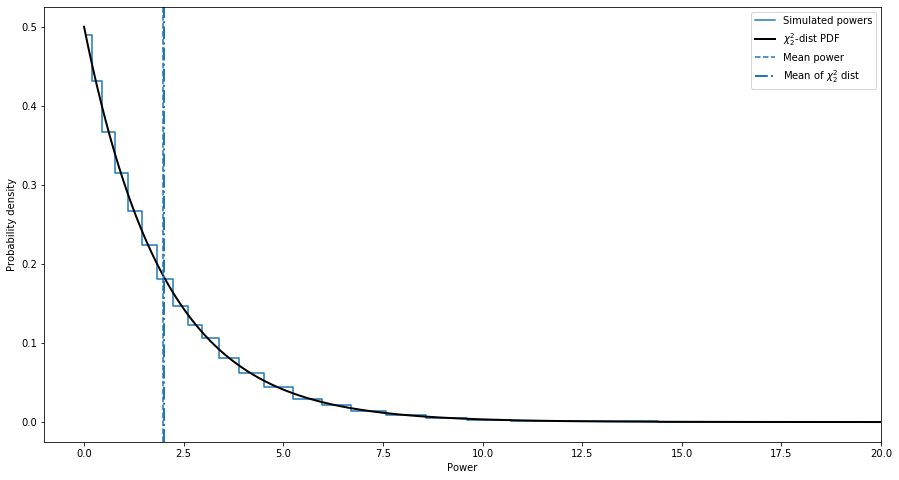

In [5]:
from scipy.stats import chi2
from astropy.stats import histogram

hist, binx = histogram(pds, bins='blocks', density=True)
powers = (binx[1:] + binx[:-1]) / 2

# PLOTTING -----------------------------
plt.plot(powers, hist, drawstyle="steps-mid", 
         label="Simulated powers")

x = np.linspace(0, 20, 10000)
chisq_pdf = chi2.pdf(x, df=2)

plt.plot(x, chisq_pdf, label=r"$\chi^2_2$-dist PDF", color='k', lw=2)
plt.axvline(np.mean(pds), ls="--", label="Mean power")
plt.axvline(2, ls="-.", lw=2, label="Mean of $\chi^2_2$ dist")
plt.xlim([None, 20])
plt.xlabel("Power")
plt.ylabel("Probability density")
plt.legend()
# -------------------------------------

This normalization is great to look for pulsations. We can say that pulsation is significantly detected in the data if the feature it produces in the power density spectrum is above a certain limit. This limit is given, of course, through the chi-squared statistics.

The detection level can be calculated through the _inverse survival function_, or finding that value of power whose probability is lower than a given small value $\epsilon$.

For example, we want to find the power value corresponding to a probability below 99% ($\epsilon=0.01$). Anything above that level will be considered a pulsar candidate.

But with noise, we expect each bin to be independent of all others. This means that if our spectrum has 10000 bins, we will have 100 detections above 99%. In practice, what one does is to divide $\epsilon$ by the number of bins in the spectrum.

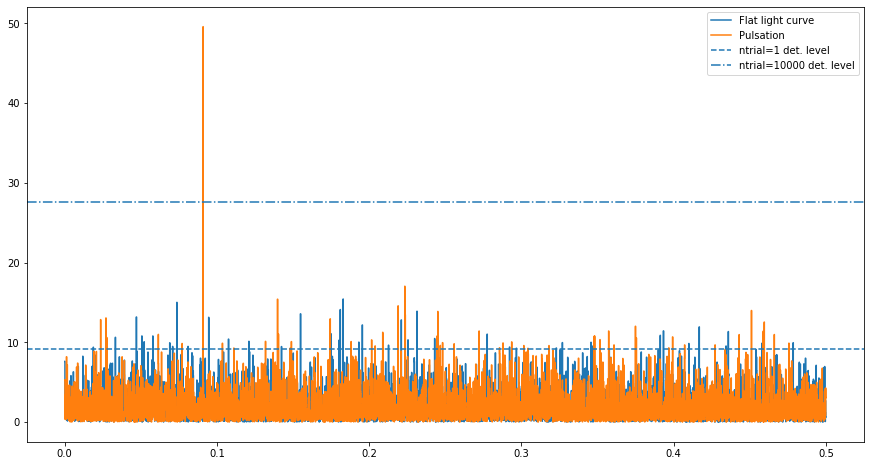

In [6]:
def detection_level(epsilon=0.01, ntrial=1, n_summed_spectra=1, n_rebin=1):
    r"""Detection level for a PDS.
    
    Return the detection level (with probability 1 - epsilon) for a Power
    Density Spectrum of nbins bins, normalized a la Leahy (1983), based on
    the 2-dof :math:`{\chi}^2` statistics, corrected for rebinning (n_rebin)
    and multiple PDS averaging (n_summed_spectra)
    """
    from scipy import stats

    retlev = stats.chi2.isf(epsilon / ntrial, 2 * n_summed_spectra * n_rebin) \
            / (n_summed_spectra * n_rebin)
    return retlev

lc = ra.poisson(10, 10000)
nbins = len(lc)
dt = 1
time = dt * np.arange(nbins)

freq, pds = rough_leahy_pds(lc, dt)

# lc with weak pulsations
frequency = 1. / 11
lc_puls = ra.poisson(10 + 0.3 * np.sin(2 * np.pi * frequency * time))

freq_puls, pds_puls = rough_leahy_pds(lc_puls, dt)

detlev = detection_level(epsilon=0.01)
detlev_ntrial = detection_level(epsilon=0.01, ntrial=10000)

# PLOTTING -------------------
plt.plot(freq, pds, drawstyle="steps-mid", label="Flat light curve")
plt.plot(freq_puls, pds_puls, drawstyle="steps-mid", label="Pulsation")

plt.axhline(detlev, label="ntrial=1 det. level", ls="--")
plt.axhline(detlev_ntrial, label="ntrial=10000 det. level", ls="-.")
plt.legend()

## Not only coherent pulsations

In general, the power spectra of accreting systems are not as simple as the "white noise + coherent peak" we saw in the first exercise.

There is usually a combination of broad and quasi-coherent noise features that carry an interest in themselves. For example:

+ Low-frequency powerlaw or broken-powerlaw noise

+ Low-frequency Quasi-periodic oscillations (LF QPOs)

+ High-frequency Quasi-periodic oscillations (HF QPOs, kHz QPOs)

Below, an example from Motta et al. 2017, MNRAS (arXiv:1703.01263)

![](QPO_NS_BH.png)

All of these features are related between them (frequencies are correlated) and they are good tracers of the spectral state of the source. Power spectra are generally modelled as combinations of Lorentzian curves, whose Q factor $Q=A/W$ (A is the amplitude, W is the width) distinguishes between quasi-periodic oscillations and broadband noise. Different authors use different conventions, but in general $Q \gtrsim 5$ indicates a QPO.

Moreover, they are often associated with physical properties of the sources, like:

+ Keplerian frequencies

+ Relativistic oscillations

+ Beats

Detecting and characterizing timing properties of the sources is thus extremely interesting and important. Even more, we can join timing and spectral properties to tackle the same observables with independent methods.

While this has the advantage of being a well-defined statistics, it is _very_ noisy. The standard way to treat it is to average over sub-intervals of data. Because of the **central limit theorem**, we expect the final distribution to be close to Gaussian.

In our case,


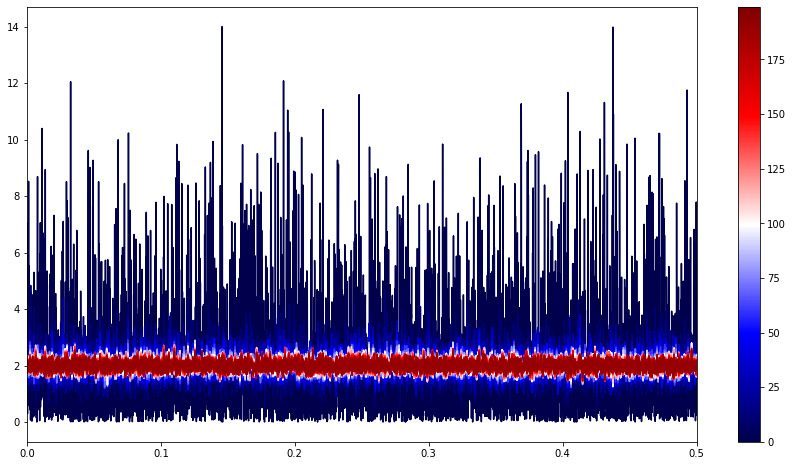

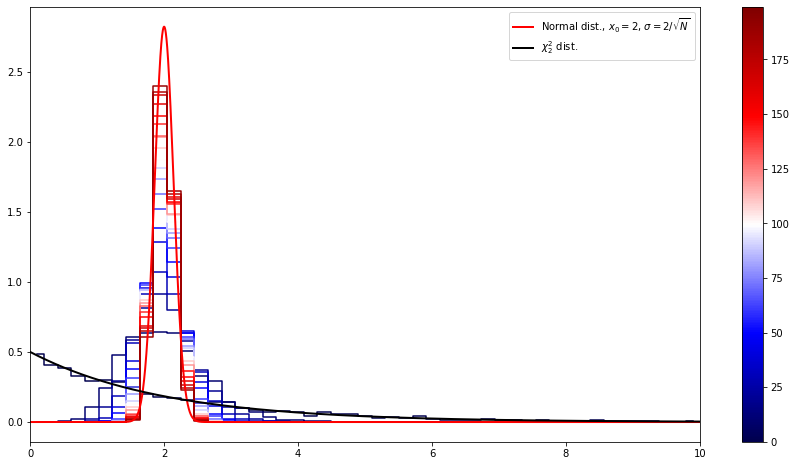

In [7]:
from scipy.stats import norm 
import matplotlib.colors as colors
import matplotlib.cm as cmx

dt = 1
total_pds = 0
x = np.linspace(0, 10, 10000)
chisq_pdf = chi2.pdf(x, df=2)
norm_pdf = chi2.pdf(x, 2, 1)

nmax = 200
values = np.arange(nmax)

# PLOTTING ---------------------------------
jet = cm = plt.get_cmap('seismic') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
scalarMap.set_array([])
# ------------------------------------------

for i in values:
    lc = ra.poisson(10, 10000)

    freq, pds = rough_leahy_pds(lc, dt)
    total_pds += pds
    
# PLOTTING ---------------------------------
    # Only every 5 PDSs (avoid clutter)
    if i % 10 != 0:
        continue
    local_ave = total_pds / (i+1)
    
    hist, binx = np.histogram(local_ave, bins=np.linspace(0, 10, 50))
    powers = (binx[1:] + binx[:-1]) / 2
    dp = np.diff(binx)

    colorVal = scalarMap.to_rgba(i)
    
    plt.figure(1)
    plt.plot(freq, local_ave, color=colorVal)
    plt.figure(2)
    plt.plot(powers, hist / np.sum(hist) / dp, drawstyle="steps-mid", color=colorVal)

plt.figure(1)
plt.xlim([0, 0.5])
plt.colorbar(scalarMap)

plt.figure(2)
plt.xlim([0, 10])
plt.plot(x, norm.pdf(x, 2, 2 / np.sqrt(nmax)), "r", lw=2, label=r"Normal dist., $x_0=2$, $\sigma=2/\sqrt{N}$")
plt.plot(x, chi2.pdf(x, 2), "k", lw=2, label=r"$\chi^2_2$ dist.")
plt.legend()
plt.colorbar(scalarMap)

# --------------------------------------


# And the Cross spectrum?

The cross spectrum is the periodogram obtained by putting together two simultaneous time series (e.g. the data from two independent detectors, or in different energy bands):
$$
C(\omega) = \dfrac{2}{\sqrt{N_{\rm ph, 1}N_{\rm ph, 2}}} \mathcal{F_1}(\omega)\mathcal{F_2}^*(\omega)
$$

Where the indices 1, 2 refer to the two light curves.

While the PDS was a _real_ quantity, the cross spectrum is _complex_. The real part of the cross spectrum is called the **cospectrum**, and the angle of the cross spectrum is called **phase lag**.

Let's take a look at the cross spectral statistics.

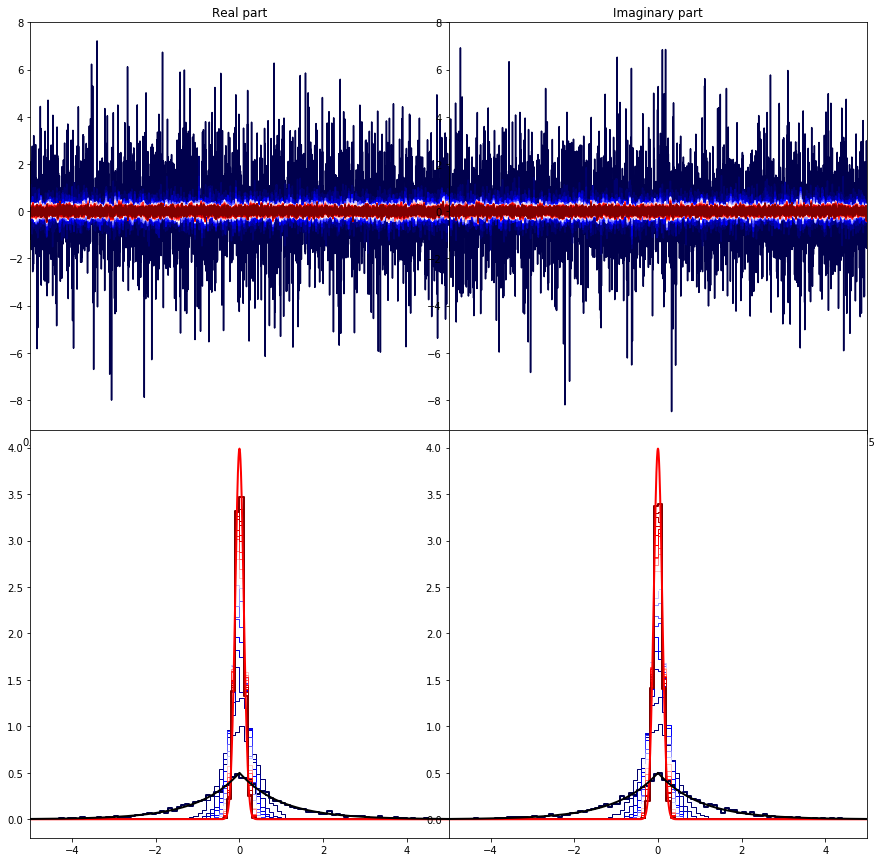

In [8]:
from scipy.stats import norm, laplace
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.gridspec import GridSpec

dt = 1
total_cpds = 0
x = np.linspace(-5, 5, 10000)
chisq_pdf = chi2.pdf(x, df=2)
norm_pdf = chi2.pdf(x, 0, 1)

nmax = 200
values = np.arange(nmax)

# PLOTTING ---------------------------------
jet = cm = plt.get_cmap('seismic') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
scalarMap.set_array([])
# ------------------------------------------

plt.figure(figsize=(15, 15))
gs = GridSpec(2, 2, hspace=0, wspace=0)
ax00 = plt.subplot(gs[0, 0])
ax01 = plt.subplot(gs[0, 1], sharey=ax00)
ax10 = plt.subplot(gs[1, 0])
ax11 = plt.subplot(gs[1, 1], sharey=ax10)

for i in values:
    lc1 = ra.poisson(10, 10000)
    lc2 = ra.poisson(10, 10000)

    freq, cpds = rough_leahy_cpds(lc1, lc2, dt)
    total_cpds += cpds
    
# PLOTTING ---------------------------------
    # Only every 5 PDSs (avoid clutter)
    if i % 10 != 0 and i != 0 and i != nmax - 1:
        continue
    if i == 0 or i == nmax - 1:
        lw = 2
    else:
        lw = 1
    local_ave = total_cpds / (i+1)
    
    hist_real, binx = np.histogram(local_ave.real, bins=np.linspace(-5, 5, 101))
    hist_imag, binx = np.histogram(local_ave.imag, bins=np.linspace(-5, 5, 101))

    powers = (binx[1:] + binx[:-1]) / 2
    dp = np.diff(binx)

    colorVal = scalarMap.to_rgba(i)
    
    ax00.plot(freq, local_ave.real, color=colorVal)
    ax01.plot(freq, local_ave.imag, color=colorVal)
    ax10.plot(powers, hist_real / np.sum(hist_real) / dp, drawstyle="steps-mid", color=colorVal, lw=lw)
    ax11.plot(powers, hist_imag / np.sum(hist_imag) / dp, drawstyle="steps-mid", color=colorVal, lw=lw)


ax00.set_xlim([0, 0.5])
ax01.set_xlim([0, 0.5])
ax10.set_xlim([-5, 5])
ax11.set_xlim([-5, 5])
ax00.set_title("Real part")
ax01.set_title("Imaginary part")

ax10.plot(x, norm.pdf(x, 0, np.sqrt(2) / np.sqrt(nmax)), "r", lw=2, label=r"Normal dist., $x_0=0$, $\sigma=2/\sqrt{N}$")
ax10.plot(x, laplace.pdf(x, 0, 1), "k", lw=2, label=r"Laplace dist., $x_0=0$, $\sigma=1$")



# ax10.plot(x, chi2.pdf(x, 2), "k", lw=2, label=r"$\chi^2_2$ dist.")
ax11.plot(x, norm.pdf(x, 0, np.sqrt(2) / np.sqrt(nmax)), "r", lw=2, label=r"Normal dist., $x_0=2$, $\sigma=2/\sqrt{N}$")
ax11.plot(x, laplace.pdf(x, 0, 1), "k", lw=2, label=r"Laplace dist., $x_0=0$, $\sigma=1$")



# ax11.plot(x, chi2.pdf(x, 2), "k", lw=2, label=r"$\chi^2_2$ dist.")
# plt.legend()
# plt.colorbar(scalarMap)

# --------------------------------------


To summarize the above results:

+ The Leahy-normalized Power Density Spectrum of a Poisson-distributed random time series follows a $\chi^2$ distribution with 2 degrees of freedom. Averaging $N$ PDS together, with $N>>1$, the resulting periodogram approaches a _Normal_ distribution with mean 2 and standard deviation $2/\sqrt{N}$

More details [in van der Klis 1989](http://www.iucaa.ernet.in/~astrosat/MIT-IUCAA_workshop_presentations/VanDerKlis1989_Fourier_Xray.pdf)

+  The imaginary and real part of a Leahy-normalized Cross Power Density Spectrum of two Poisson-distributed random time series with the same mean follow a _Laplace_ distribution with mean 0 and standard deviation 1. Averaging $N$ CPDS together, with $N>>1$, the resulting periodogram approaches a _Normal_ distribution with mean 0 and standard deviation $\sqrt{2/N}$

More details on cross spectra: [Huppenkothen & Bachetti 2019](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...13H/abstract)

## Optimizing your Binning

If we calculate the power density spectrum as described above, we might obtain something similar to this:

Text(0, 0.5, 'Power')

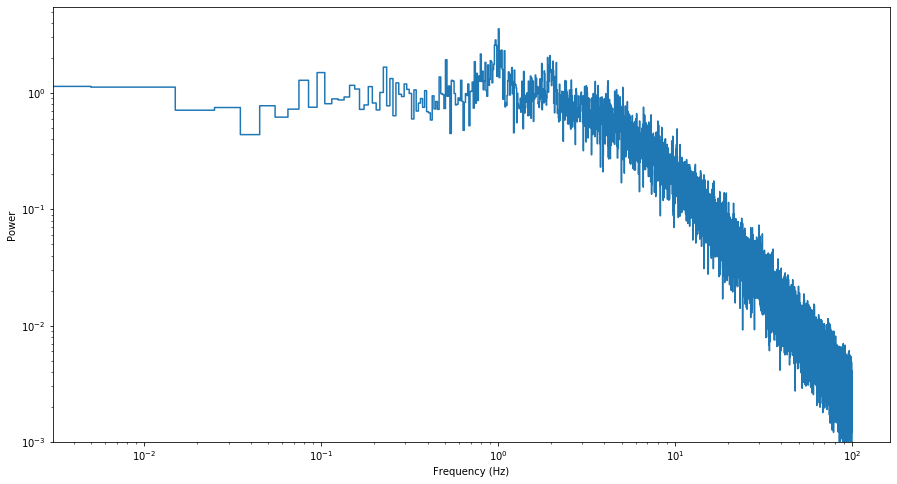

In [9]:
red_noise = Lorentz1D(x_0=0, amplitude=1, fwhm=10)
qpo = Lorentz1D(x_0=1, amplitude=1, fwhm=0.2)
qpo_harm = Lorentz1D(x_0=2, amplitude=0.5, fwhm=0.2)
qpo_hf = Lorentz1D(x_0=30, amplitude=0.01, fwhm=1)

shape_fun = red_noise + qpo + qpo_harm + qpo_hf

pds = timmer_and_koenig_pds(shape_fun(frequencies), n_ave=10)

# PLOTTING ------------------------

plt.loglog(frequencies, pds, drawstyle="steps-mid")

plt.ylim([1e-3, None])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
# ---------------------------------

We see that this spectrum is very noisy. The features do not "stand out", in particular the one at high frequencies. Binning helps to make them more evident.

The effect of binning is the same as the averaging of multiple power spectra. The power spectrum tends to approach a Gaussian distribution with mean 2 and standard deviation $2/\sqrt{NM}$, where N is the number of summed spectra and M is the number of averaged bins.

(0.001, 4.768536630505539)

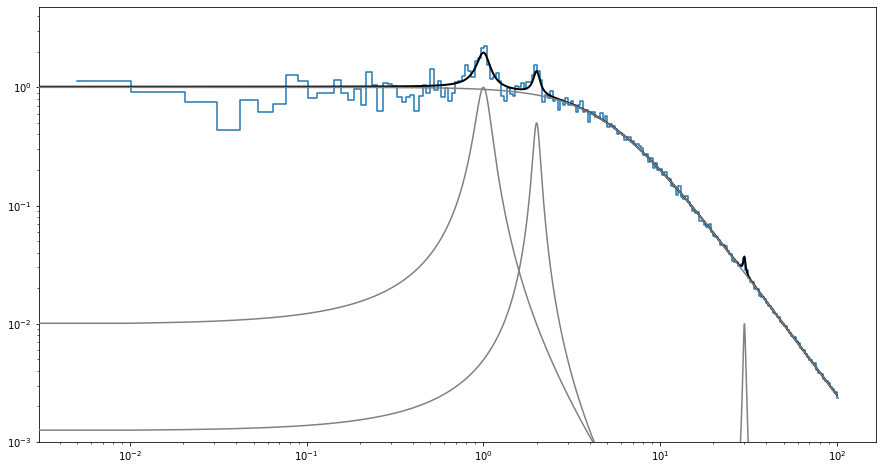

In [11]:
from stingray.utils import rebin_data_log
freq_reb, pds_reb, _, _ = rebin_data_log(frequencies, pds, 0.03)

freq_reb = (freq_reb[1:] + freq_reb[:-1]) / 2
# flo, fhi, pds_reb = retval.flo, retval.fhi, retval.pds
# freq_reb = (fhi + flo) / 2

# PLOTTING ------------------------

plt.loglog(frequencies, shape_fun(frequencies), zorder=10, color="k", lw=2)
plt.loglog(frequencies, qpo(frequencies), zorder=10, color="grey")
plt.loglog(frequencies, qpo_harm(frequencies), zorder=10, color="grey")
plt.loglog(frequencies, qpo_hf(frequencies), zorder=10, color="grey")

plt.loglog(frequencies, red_noise(frequencies), zorder=10, color="grey")

plt.loglog(freq_reb, pds_reb, drawstyle="steps-mid")
plt.ylim([1e-3, None])

# -------------------------------

See now as all QPOs stand out clearly from the broadband noise.

A good binning should improve the statistics without averaging too much signal with noise. In practice, it is often a trial-and-error procedure.

## Dead time

When an X-ray detector receives a photon, it spends a few instants to process the event (record the event, assign a timestamp, an energy channel, the position ...). During this interval of time, called _dead time_, the detector does not record any events. 

In satellites where timing is a major issue and count rates are very high the dead time is held very small (e.g. 10 $\mu$s for RXTE). In spectroscopic missions, where the calculation of the energy of the photon is done very accurately, dead time often turns out to be very high. For example, for NuSTAR it is 2.5 ms. 

More details, as usual, [In the X-ray timing sacred book by M. van der Klis](http://www.iucaa.ernet.in/~astrosat/MIT-IUCAA_workshop_presentations/VanDerKlis1989_Fourier_Xray.pdf)

How to correct for dead time in multi-instrument detectors: [Bachetti & Huppenkothen 2019](https://ui.adsabs.harvard.edu/abs/2018ApJ...853L..21B/abstract)

A quick demonstration:

INFO: filter_for_deadtime: 6026/30000 events rejected [hendrics.fake]


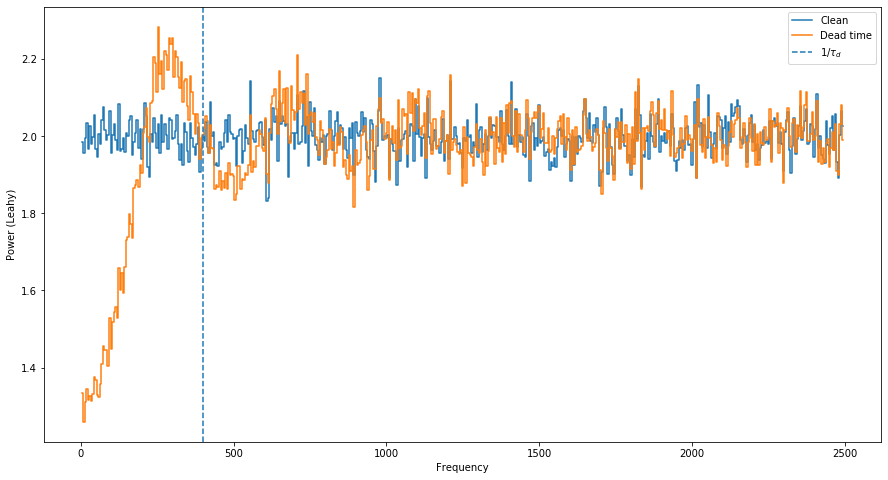

In [12]:
from hendrics.fake import filter_for_deadtime
from stingray.lightcurve import Lightcurve
from stingray.powerspectrum import AveragedPowerspectrum

import numpy.random as ra
obs_duration = 300
dt = 0.0002

count_rate = 100  # counts/s
deadtime = 2.5e-3

# generate events
events = ra.uniform(0, obs_duration, obs_duration * count_rate)
events.sort()
# filter for dead time
events_dead = filter_for_deadtime(events, deadtime)
# light curves

lc = Lightcurve.make_lightcurve(events, dt, tstart=0, tseg=obs_duration)
lc_dead = Lightcurve.make_lightcurve(events_dead, dt, tstart=0, tseg=obs_duration)

pds = AveragedPowerspectrum(lc, 0.2, norm='leahy')
pds_dead = AveragedPowerspectrum(lc_dead, 0.2, norm='leahy')

# PLOTTING -------------------
plt.plot(pds.freq, pds.power, drawstyle="steps-mid", label="Clean")
plt.plot(pds_dead.freq, pds_dead.power, drawstyle="steps-mid", label="Dead time")

plt.xlabel("Frequency")
plt.ylabel("Power (Leahy)")

plt.axvline(1 / deadtime, label = r"$1/\tau_d$", ls="--")

plt.legend()

## Gaps

Fourier techniques rely on ininterrupted data. Gaps in the data (e.g., out of GTIs) produce spurious variability that has to be taken into account. Always better to select light curve intervals with no gaps before calculating the PDS.

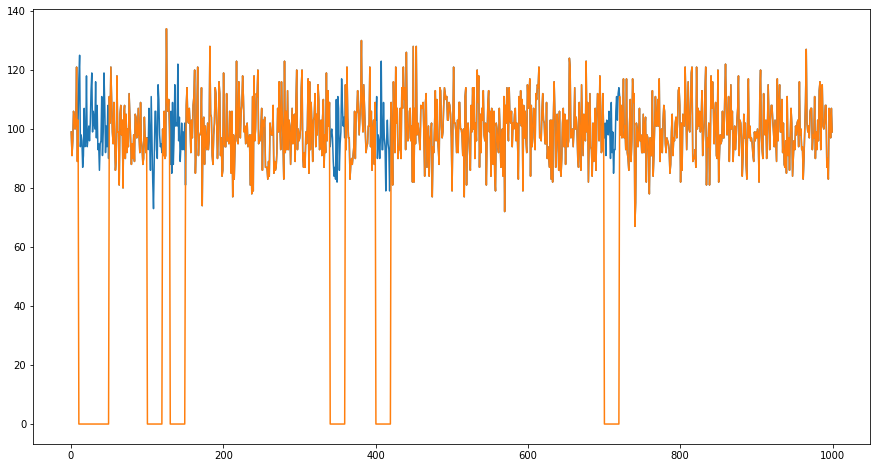

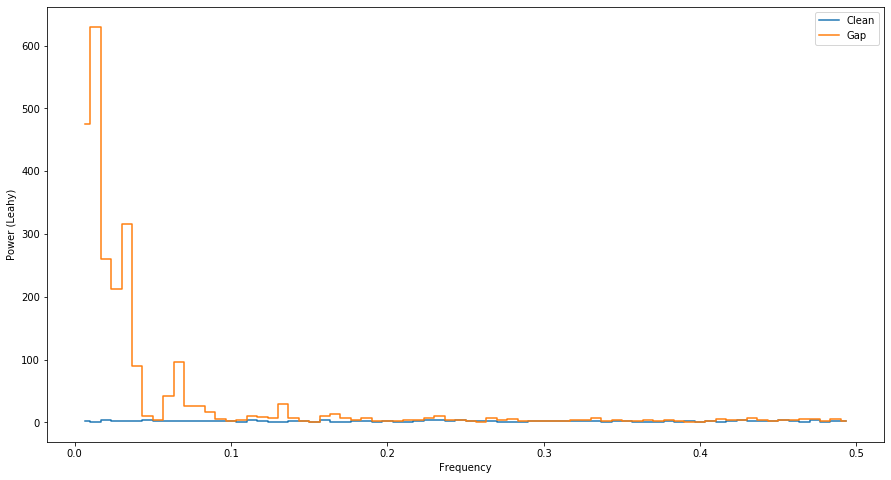

In [13]:
import copy
obs_duration = 1000
dt = 1

count_rate = 100  # counts/s
deadtime = 2.5e-3

# generate events
events = ra.uniform(0, obs_duration, obs_duration * count_rate)
events.sort()

lc = Lightcurve.make_lightcurve(events, dt, tstart=0, tseg=obs_duration)

lc_gap = copy.deepcopy(lc)

for i in [10, 30, 100, 130, 400, 340, 700]:
    lc_gap.counts[i:i + 20] = 0

pds = AveragedPowerspectrum(lc, 150, norm='leahy')
pds_gap = AveragedPowerspectrum(lc_gap, 150, norm='leahy')


# PLOTTING -------------------
plt.figure(1)
plt.plot(lc.time, lc.counts, label="Clean")
plt.plot(lc.time, lc_gap.counts, label="Gap")

plt.figure(2)
plt.plot(pds.freq, pds.power, drawstyle="steps-mid", label="Clean")
plt.plot(pds_gap.freq, pds_gap.power, drawstyle="steps-mid", label="Gap")

plt.xlabel("Frequency")
plt.ylabel("Power (Leahy)")

plt.legend()